In [1]:
using Plots, Random, FFTW, Colors, Statistics, LinearAlgebra, EllipsisNotation,
    BenchmarkTools, Wavelets, PaddedViews, Distributed, MATLAB

## Read Data

In [10]:
d₁, d₂, d₃, m = 300, 224, 48, 4
kSpace_orig = Array{ComplexF32}(undef, d₁, d₂, d₃, m)
read!("../data.dat", kSpace_orig)
kSpace_orig = ntoh.(kSpace_orig) # big-endian to system default
kSpace_CF64_orig = ComplexF64.(kSpace_orig);

## Prepare Data
Normalize data, discard phase, and keep only first slice

In [11]:
image4D_shifted_orig = abs.(ifft(kSpace_CF64_orig, [1,2,3]))            # Discard phase
image4D_shifted = image4D_shifted_orig ./ maximum(image4D_shifted_orig) # Normalization
image3D_shifted = dropdims(mean(abs.(image4D_shifted), dims=4), dims=4)
image3D = fftshift(image3D_shifted, (1,3));
image2D = image3D[:,:,1]
kSpace = rfft(image2D, [1,2]);

In [12]:
kspaceSize = size(kSpace)
imSize = size(image2D)
kspaceType, imageType = typeof(kSpace), typeof(image2D);

## Visualize

In [13]:
function imshow(img::Array{T, 2}) where T<:Number
    plot(Gray.(img'), seriestype=:image)
end

imshow (generic function with 1 method)

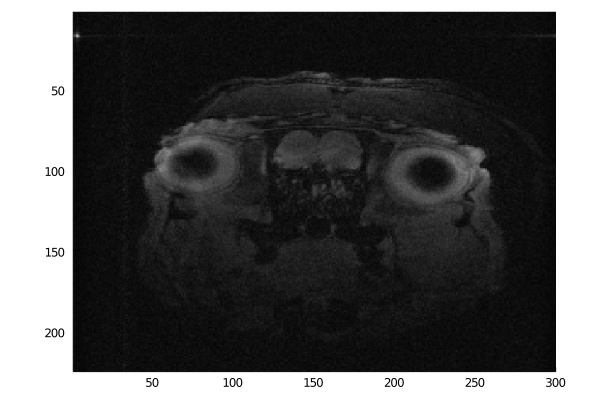

In [14]:
imshow(image2D)

## Simulate Imaging
`mode`:
 - `"2D randomization"`: same randomization in each slice and each measurement
 - `"3D randomization"`: same randomization in each measurement, but different at each slice
 - `"4D randomization"`: different randomization in each slice and each measurement

In [15]:
function create_mask(d₁, d₂, d₃, m, factor, mode)
    # Generate a valid but not randomized sampling mask
    slice_mask = zeros(d₁, d₂)
    number_of_sampled_rows = floor(Int, d₁ / factor)
    slice_mask[1:number_of_sampled_rows, :] .= 1
    mask = repeat(slice_mask, 1, 1, d₃, m)
    
    # Randomize sampling mask
    mode == "2D randomization" && (perm = randperm(d₁))
    for i = 1:d₃
        mode == "3D randomization" && (perm = randperm(d₁))
        for j = 1:m
            mode == "4D randomization" && (perm = randperm(d₁))
            mask[:,:,i,j] = mask[perm,:,i,j]
        end
    end
    mask .== 1
end

create_mask (generic function with 1 method)

In [16]:
function create_mask(d₁, d₂, factor)
    # Generate a valid but not randomized sampling mask
    mask = zeros(d₁, d₂)
    number_of_sampled_rows = floor(Int, d₁ / factor)
    mask[1:number_of_sampled_rows, :] .= 1
    
    # Randomize sampling mask
    mask[randperm(d₁),:] .== 1
end

create_mask (generic function with 2 methods)

In [17]:
factor = 1.5
mask = create_mask(kspaceSize...,factor);

In [18]:
plan = plan_rfft(image2D, [1,2])
inv_plan = plan_irfft(kSpace, imSize[1], [1,2])
Fᵤ(x) = mask .* (plan * x)
Fᵤ(b, x) = b .= mask .* mul!(b, plan, x)
inv_Fᵤ(x) = inv_plan * x
inv_Fᵤ(b, x) = mul!(b, inv_plan, x)

inv_Fᵤ (generic function with 2 methods)

In [19]:
y = Fᵤ(image2D);

## Baseline: Zero-filling reconstruction

In [20]:
mse = img -> norm(img - image2D)

#1 (generic function with 1 method)

In [21]:
image2D_zf = inv_Fᵤ(y);
@show mse(image2D_zf);

mse(image2D_zf) = 9.756097776284312


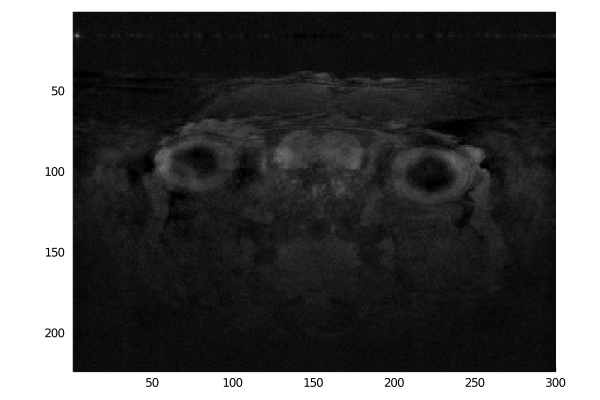

In [22]:
imshow(image2D_zf)

## Compressed Sensing

### Image reconstruction
- **TV (Total Variance):** L1 norm of finite differences image
- **Original problem** to be solved: *minimize* $\lvert\lvert \Psi m \rvert\rvert_1$ *such that* $\lvert\lvert \mathcal{F}_u m - y \rvert\rvert_2 < \epsilon$
  - it is an constrainted convex optimization problem
- Consider the **unconstrainted problem** in **Lagrangian form**: $argmin_m \lvert\lvert\mathcal{F}_u m - y \rvert\rvert_2^2 + \lambda \lvert\lvert\Psi m \rvert\rvert_1$, where $\lambda$ is a regularization paramater that determines the trade-off between data consistency and sparsity
  - if $\lambda$ properly selected, then the two problem statements yield same results
  - $\lambda$ can be determined by trying many values and choosing one so that $\lvert\lvert\mathcal{F}_u m - y \rvert\rvert_2 \approx \epsilon$
- **Unconstrained problem then can be solved** by nonlinear conjugate gradient descent (CG) algorithm using $f(m) = argmin_m \lvert\lvert\mathcal{F}_u m - y \rvert\rvert_2^2 + \lambda \lvert\lvert\Psi m \rvert\rvert_1$ as cost function
- Computation of $\mathcal{F}_u f(m)$
  - $\nabla f(m) = 2 \mathcal{F}_u^*(\mathcal{F}_u m - y) + \lambda \nabla \lvert\lvert \Psi m \rvert\rvert_1$
  - $\mathcal{l}^1$ norm is sum of absolute values → Problem: absolute value funciton is not a smooth functions → equation above is not well-defined for all values of $m$
  - Instead of absolute value function we use a smooth function: $\lvert x \rvert \approx \sqrt{x*x + \mu}$, where $\mu$ is a positive smoothing parameter
    - With this approximation: $\frac{d \lvert x \rvert}{dx} \approx \frac{x}{\sqrt{x*x + \mu}}$
  - Let $W$ be a diagonal matrix with diagonal elements $w_i = \sqrt{(\Psi m)_i*(\Psi m)_i + \mu}$
    - Then $\nabla f(m) = 2 \mathcal{F}_u^*(\mathcal{F}_u m - y) + \lambda \Psi^* W^{-1} \Psi m$
  - In practice $\mu \in [10^{-15}, 10^{-6}]$ 

### Smoothed L1 norm

In [444]:
μ = 1e-15
abs_smooth(x) = sqrt(x * conj(x) + μ)
norm₁(v) = sum(abs_smooth, v)
∇norm₁(v) = v ./ abs_smooth.(v)

∇norm₁ (generic function with 1 method)

In [414]:
norm₂(x) = norm(x)
norm₂²(x) = abs(vec(x)' * vec(x))

norm₂² (generic function with 1 method)

## Sparsifying transform

In [25]:
wt = wavelet(WT.Daubechies{4}(), WT.Filter, WT.Periodic)
power_two_size = 2 .^ (ceil.(Int, log2.(size(image2D))))
Ψ(b, x) = begin
        img = PaddedView(0, x, power_two_size)
        dwt!(b, img, wt)
    end
Ψ(x) = Ψ(similar(x, power_two_size), x)
temp_wavelet = similar(image2D, power_two_size)
inv_Ψ(b, x) = begin
        idwt!(temp_wavelet, x, wt)
        b .= temp_wavelet[[1:i for i in imSize]...]
    end
inv_Ψ(x) = inv_Ψ(similar(x, imSize), x)

inv_Ψ (generic function with 2 methods)

In [26]:
test = Ψ(image2D);

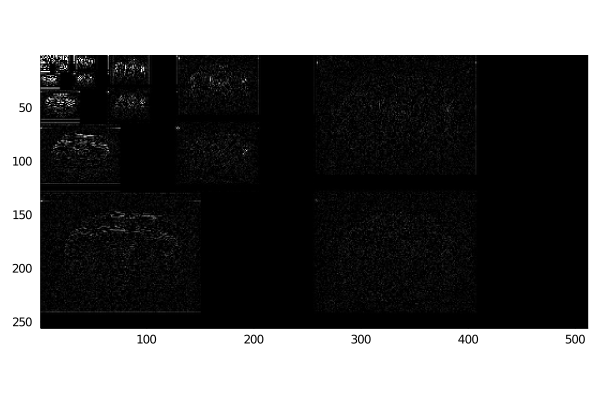

In [27]:
imshow(test*4)

### Cost function

In [28]:
λ₁, λ₂ = 1e-2, 0.01
precalc_f(x, dx) = Fᵤ(inv_Ψ(x)), Fᵤ(inv_Ψ(dx))
f(F_iΨ_x, F_iΨ_dx, x, dx, t) = norm(F_iΨ_x + t*F_iΨ_dx - y) + λ₁ * norm₁(x + t*dx)
∇f(x) = 2 * Ψ(inv_Fᵤ(Fᵤ(inv_Ψ(x)) - y)) + λ₁ * ∇norm₁(x)

∇f (generic function with 1 method)

In [29]:
x = Ψ(image2D_zf)
dx = ∇f(x)
F_iΨ_x, F_iΨ_dx = precalc_f(x, dx)
t = 0.001
f(F_iΨ_x, F_iΨ_dx, x, dx, t)

0.27558297545335136

### Nonlinear Conjugate Gradient Descent with backtracking linear search

**Inputs**:
 - $y$: k-space measurements
 - $m_0$: initial value for reconstructed image
 - $f$: cost function
 - $\nabla f$: gradient of cost function
 - $\lambda$: data consistency tuning constant
 - TolGrad: stopping criteria by gradient magnitude (optional, default: $10^{-4}$)
 - MaxIter: stopping criteria by number of iterations (optional, default: $100$)
 - LinSearchMaxIter: stopping criteria for linear search (optional, default: $150$)
 - $\alpha, \beta$: line search parameters (optional, defaults: $\alpha = 0.05, \beta = 0.6$)

**Outputs**
 - $m$: numerical approximation for the image

In [451]:
function optimize(y, m₀, f, ∇f; TolGrad = 10e-4, MaxIter = 100, LinSearchMaxIter = 150, α = 0.05, β = 0.6)
    k, mₖ, gₖ = 1, m₀, ∇f(m₀)
    Δmₖ = -gₖ
    
    while norm₂(gₖ) > TolGrad && k < MaxIter
        (k % length(y) == 0) && (Δmₖ = -gₖ) # restart in every n-th iteration!
        
        F_iΨ_mₖ, F_iΨ_Δmₖ = precalc_f(mₖ, Δmₖ)
        t, l = 1, 1
        f₀ = f(F_iΨ_mₖ, F_iΨ_Δmₖ, mₖ, Δmₖ, t)
        while f(F_iΨ_mₖ, F_iΨ_Δmₖ, mₖ, Δmₖ, t) > f₀ - α * t * abs(vec(gₖ)' * vec(Δmₖ))^2
            t *= β
            l += 1
            if l == LinSearchMaxIter
                println("Limit for number of iterations in linear search is reached! (t = $t)")
                return mₖ
            end
        end
        println("Cost: ", f(F_iΨ_mₖ, F_iΨ_Δmₖ, mₖ, Δmₖ, t), "\tstep size: ", t)
        mₖ₊₁ = mₖ + t*Δmₖ
        gₖ₊₁ = ∇f(mₖ₊₁)
        γ = norm₂²(gₖ₊₁) / norm₂²(gₖ) # Fletcher-Reeves
        #γ = gₖ₊₁[:]' *  (gₖ₊₁[:] - gₖ[:]) / norm₂²(gₖ) # Polak-Ribiere
        Δmₖ₊₁ = -gₖ₊₁ + γ * Δmₖ
        gₖ, mₖ, Δmₖ, k = gₖ₊₁, mₖ₊₁, Δmₖ₊₁, k + 1
    end
    
    mₖ
end

optimize (generic function with 1 method)

In [31]:
image2D_cs = optimize(y, Ψ(image2D_zf), f, ∇f);

Cost: 1.2403006536799295	step size: 0.6
Limit for number of iterations in linear search is reached! (t = 8.801086859902593e-34)


In [396]:
TV(image) = begin
    ∇ₓ, ∇ᵧ = copy(image), copy(image)
    ∇ₓ[1:end-1,:] .-= image[2:end,:]
    ∇ₓ[end,:] .= zero(eltype(image))
    ∇ᵧ[:,1:end-1] .-= image[:,2:end]
    ∇ᵧ[:,end] .= zero(eltype(image))
    cat(∇ₓ, ∇ᵧ, dims=ndims(image)+1)
end
inv_TV(image) = begin
    function dx(x)
        res = copy(x)
        res[2:end-1,:] .-= @view x[1:end-2,:]
        res[1,:] .*= -one(eltype(image))
        res[end,:] .= @view x[end-1,:]
        res
    end

    function dy(y)
        res = copy(y)
        res[:,2:end-1] .-= @view y[:,1:end-2]
        res[:,1] .*= -one(eltype(image))
        res[:,end] .= @view y[:,end-1]
        res
    end

    dx(image[:,:,1]) + dy(image[:,:,2])
end

inv_TV (generic function with 1 method)

In [104]:
factor = 1.5
mask = create_mask(size(img)...,factor);

In [116]:
plan = plan_fft(img, [1,2])
inv_plan = plan_ifft(plan * img, [1,2])
Fᵤ(x) = mask .* (plan * x)
Fᵤ(b, x) = b .= mask .* mul!(b, plan, x)
inv_Fᵤ(x) = abs.(inv_plan * x)
inv_Fᵤ(b, x) = abs.(mul!(b, inv_plan, x))

inv_Fᵤ (generic function with 2 methods)

In [98]:
wt = wavelet(WT.Daubechies{4}(), WT.Filter, WT.Periodic)
Ψ(b, x) = dwt!(b, img, wt)
Ψ(x) = Ψ(similar(x, size(img)), x)
inv_Ψ(b, x) = idwt!(b, x, wt)
inv_Ψ(x) = inv_Ψ(similar(x, size(img)), x)

inv_Ψ (generic function with 2 methods)

In [369]:
plan = plan_rfft(image2D, [1,2])
inv_plan = plan_irfft(plan * image2D, size(image2D, 1), [1,2]);

In [370]:
factor = 1.5
data = plan * image2D
mask = create_mask(size(data)...,factor);

In [371]:
normalizer = √(length(image2D) / 2) 
Fᵤ(x) = 1/normalizer * (plan * x) .* mask
inv_Fᵤ(x) = normalizer * (inv_plan * x)

inv_Fᵤ (generic function with 2 methods)

In [373]:
oneTo(x) = 1:x
wt = wavelet(WT.Daubechies{4}(), WT.Filter, WT.Periodic)
power_two_size = 2 .^ (ceil.(Int, log2.(size(image2D))))
Ψ(x) = dwt(PaddedView(0, x, power_two_size), wt)
inv_Ψ(x) = idwt(x, wt)[oneTo.(size(image2D))...]

In [407]:
y = Fᵤ(image2D);

In [417]:
f(x) = norm₂²(Fᵤ(inv_Ψ(x)) - y) + xfmWeight * norm₁(x) + TVWeight * norm₁(TV(inv_Ψ(x)))
∇f(x) = 2 * Ψ(inv_Fᵤ(Fᵤ(inv_Ψ(x)) - y)) + xfmWeight * ∇norm₁(x) + 
    TVWeight.*Ψ(inv_TV(∇norm₁(TV(inv_Ψ(x)))))

∇f (generic function with 1 method)

In [445]:
N = size(image2D);     # image Size
DN = size(image2D);    # data Size
TVWeight = 0.002;      # Weight for TV penalty
xfmWeight = 0.0005;     # Weight for Transform L1 penalty
Itnlim = 20;            # Number of iterations

#factor = 1.5;
#mode = '2D randomization';
#mask = squeeze(create_mask(N(1), N(2), 1, 1, factor, mode));
pdf = ones(N);

#generate Fourier sampling operator
#FT = p2DFT(mask, N, 1, 2);
data = Fᵤ(image2D);

# scale data
#im_dc = FT'*(data.*mask./pdf);
#data = data/max(abs(im_dc(:)));
#im_dc = im_dc/max(abs(im_dc(:)));

#generate transform operator
#XFM = Wavelet('Daubechies',4,4);    # Wavelet

#generate TV operator
#TV = TVOP;

gradToll = 1e-30;    # step size tollerance stopping criterea (not used)
l1Smooth = 1e-15;    # smoothing parameter of L1 norm
    
# line search parameters
lineSearchItnlim = 150;
lineSearchAlpha = 0.01;
lineSearchBeta = 0.6;
lineSearchT0 = 1 ; # step size to start with

x = Ψ(rand(size(image2D)...))

# line search parameters
maxlsiter = lineSearchItnlim;
alpha = lineSearchAlpha;
beta = lineSearchBeta;
t0 = lineSearchT0;
k = 0;

#Dx = TV(inv_Ψ(x));
#g0 = Ψ(inv_Fᵤ(Fᵤ(inv_Ψ(x)) - data))*2 +
#    xfmWeight.*x.*(x.*conj.(x) .+ l1Smooth).^(-1/2) +
#    TVWeight.*Ψ(inv_TV(Dx.*(Dx.*conj.(Dx) .+ l1Smooth).^(-1/2)));
g0 = ∇f(x)

dx = -g0;

# iterations
while true

# backtracking line-search

    # pre-calculate values, such that it would be cheap to compute the objective
    # many times for efficient line-search
    #FTXFMtx = Fᵤ(inv_Ψ(x));
    #FTXFMtdx = Fᵤ(inv_Ψ(dx));
    #DXFMtx = TV(inv_Ψ(x));
    #DXFMtdx = TV(inv_Ψ(dx));

    t=0;
    #obj = FTXFMtx + t*FTXFMtdx - data;
    #obj = vec(obj)'*vec(obj);
    #w = vec(DXFMtx) + t*vec(DXFMtdx);
    #TV_val = TVWeight*norm₁(w);
    #w = vec(x) + t*vec(dx); 
    #XFM_val = xfmWeight*norm₁(w);
    #f0 = abs(obj + TV_val + XFM_val)
    f0 = f(x)

    t = t0;
    #obj = FTXFMtx + t*FTXFMtdx - data;
    #obj = vec(obj)'*vec(obj);
    #w = vec(DXFMtx) + t*vec(DXFMtdx);
    #TV_val = TVWeight*norm₁(w);
    #w = vec(x) + t*vec(dx); 
    #XFM_val = xfmWeight*norm₁(w);
    #RMSerr = sqrt(obj/sum(abs, vec(data)));
    #f1 = abs(obj + TV_val + XFM_val)
    f1 = f(x + t*dx)

    lsiter = 0;

    while (f1 > f0 - alpha*t*abs(vec(g0)'*vec(dx)))^2 && (lsiter<maxlsiter)
        lsiter = lsiter + 1;
        t = t * beta;
        #obj = FTXFMtx + t*FTXFMtdx - data;
        #obj = vec(obj)'*vec(obj);
        #w = vec(DXFMtx) + t*vec(DXFMtdx);
        #TV_val = TVWeight*norm₁(w);
        #w = vec(x) + t*vec(dx); 
        #XFM_val = xfmWeight*norm₁(w);
        #RMSerr = sqrt(obj/sum(abs, vec(data)));
        #f1 = abs(obj + TV_val + XFM_val)
        f1 = f(x + t*dx)
    end

    if lsiter == maxlsiter
        println("Reached max line search,.... not so good... "*
            "might have a bug in operators. exiting... ");
        break;
    end

    # control the number of line searches by adapting the initial step search
    if lsiter > 2
        t0 = t0 * beta;
    end 

    if lsiter<1
        t0 = t0 / beta;
    end

    x = (x + t*dx);

    println("$k, obj: $f1, RMS: $(mse(inv_Ψ(x))), L-S: $lsiter");

    #conjugate gradient calculation

    #Dx = TV(inv_Ψ(x));
    #g1 = Ψ(inv_Fᵤ(Fᵤ(inv_Ψ(x)) - data))*2 +
    #    xfmWeight.*x.*(x.*conj.(x) .+ l1Smooth).^(-1/2) +
    #    TVWeight.*Ψ(inv_TV(Dx.*(Dx.*conj.(Dx) .+ l1Smooth).^(-1/2)));
    g1 = ∇f(x)
    bk = vec(g1)'*vec(g1)/(vec(g0)'*vec(g0)+eps(real(eltype(g0))))
    g0 = g1;
    dx =  - g1 + bk* dx;
    k = k + 1;

    #TODO: need to "think" of a "better" stopping criteria ;-)
    if (k > Itnlim) || (norm(vec(dx)) < gradToll) 
        break;
    end

end

im_res = inv_Ψ(x);

0, obj: 228.98976503404256, RMS: 116.48752298980757, L-S: 1
1, obj: 115.4945935490588, RMS: 115.57346995573094, L-S: 0
2, obj: 87.0863890408609, RMS: 114.52177192913744, L-S: 0
3, obj: 83.45666554425927, RMS: 113.36573849385685, L-S: 1
4, obj: 42.46239333934797, RMS: 111.67134653400346, L-S: 1
5, obj: 36.20391490211192, RMS: 111.20352130776796, L-S: 2
6, obj: 31.783923125204844, RMS: 109.96442117719356, L-S: 0
7, obj: 26.685675293604532, RMS: 108.99188936166198, L-S: 2
8, obj: 21.254656969029895, RMS: 108.55562595204425, L-S: 2
9, obj: 19.22607299127251, RMS: 108.49205113925579, L-S: 3
10, obj: 17.513341612584988, RMS: 108.29193106513195, L-S: 1
11, obj: 16.171131206787116, RMS: 108.02248300126232, L-S: 1
12, obj: 12.650465934640598, RMS: 107.85612528183917, L-S: 2
13, obj: 11.003861143771474, RMS: 107.79921448564674, L-S: 3
14, obj: 10.51643868762618, RMS: 107.6663555344165, L-S: 0
15, obj: 9.700559427549543, RMS: 107.56368172058609, L-S: 3
16, obj: 8.515801739156709, RMS: 107.5266915

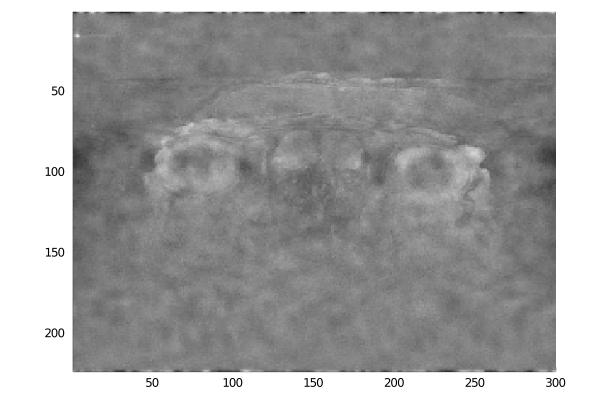

In [446]:
imshow(im_res)

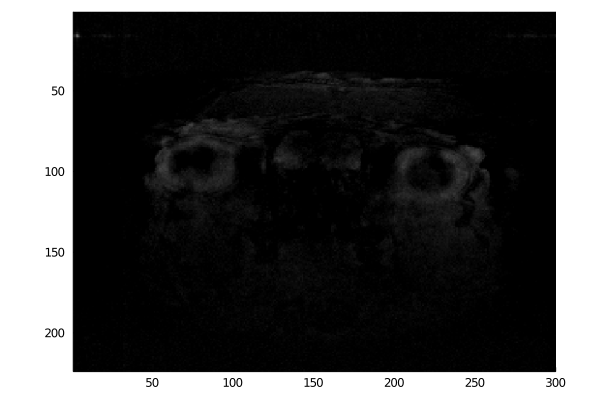

In [421]:
imshow(inv_Fᵤ(data))